# Model Comparison

## Krotov and Hopfield

The respective code can be found at: [Biological Learning](https://github.com/DimaKrotov/Biological_Learning). The code is in accordance with [Unsupervised Learning With Competing Hidden Units](https://www.pnas.org/doi/10.1073/pnas.1820458116).

In [440]:
# Load MNIST data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10
N=784
Ns=60000
M=np.zeros((0,N), dtype=np.double)
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0


In [204]:
# PARAMETERS
eps0=2e-2    # learning rate
Kx=10
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

In [6]:
synapses = np.random.normal(mu, sigma, (hid, N))
for nep in range(Nep):
    eps=eps0*(1-nep/Nep)
    M=M[np.random.permutation(Ns),:]
    for i in range(Ns//Num):
        inputs=np.transpose(M[i*Num:(i+1)*Num,:])
        sig=np.sign(synapses)
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        
        y=np.argsort(tot_input,axis=0)
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta
        
        xx=np.sum(np.multiply(yl,tot_input),1)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
        
        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)

In [3]:
synapses = np.random.normal(mu, sigma, (hid, N))

In [11]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    #plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    #fig.canvas.draw()   

In [14]:
#%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt
fig=plt.figure(figsize=(12.9,10))
draw_weights(synapses, Kx, Ky)
fig.show()

<IPython.core.display.Javascript object>

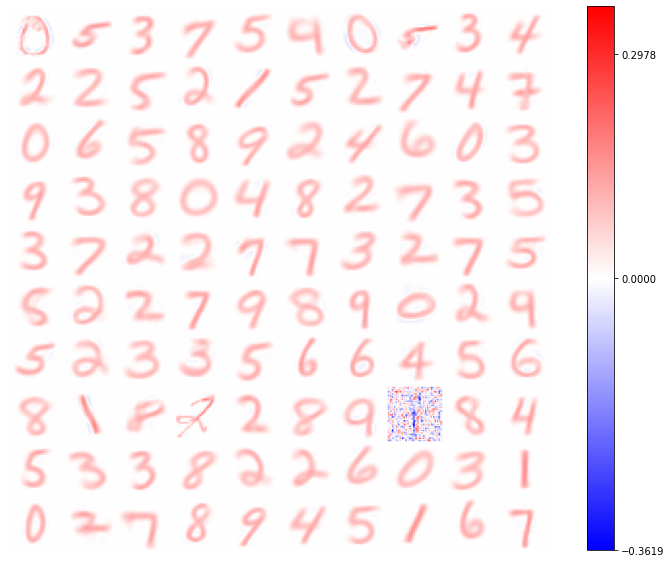

In [7]:
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

## Konstantin's model

In order to compare, we need the same data. Hence, we load the MNIST-set the same way but construct minibatches out of it so our model can make sense of it.

In [10]:
# Load MNIST data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10
N=784
Ns=60000
M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

In [18]:
import torch

if torch.cuda.is_available():
    dev = torch.device('cuda')
    print(f"Cuda available, choose device: {dev}")
else:
    dev = torch.device('cpu')
    print(f"Cuda unavailable, choose device: {dev}")

M_tensor = torch.Tensor(M)
M_tensor = M_tensor.to(dev)
M_tensor = M_tensor.reshape(Ns, 28, 28)

Cuda available, choose device: cuda


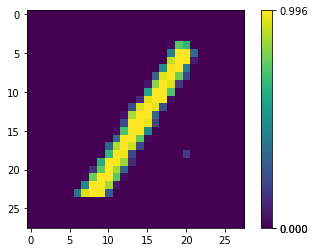

In [24]:
fig, ax = plt.subplots()
HM = M_tensor[10000].detach().cpu().numpy()
im = ax.imshow(HM)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
fig.show()

In [205]:
# torch related modules and libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# other
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# custom modules and libraries
from context import LocalLearning

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [31]:
llPSet = LocalLearning.FKHL3.pSet
llPSet["hidden_size"]= hid*N

model = LocalLearning.FKHL3(llPSet)

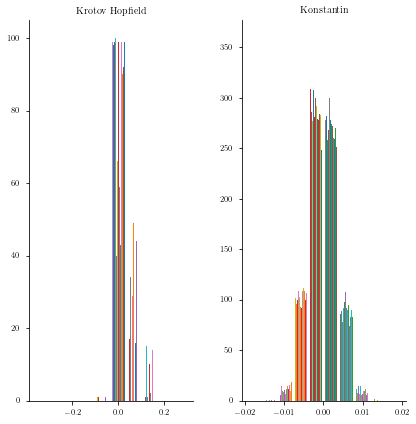

In [34]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(synapses)
axs[0].set_title("Krotov Hopfield")
axs[1].hist(model.W.detach().cpu().numpy())
axs[1].set_title("Konstantin")
fig.show()

### Comparison

In [530]:
from torch import nn
from torch import Tensor, DoubleTensor
import math

class KHL3(nn.Module):
    """
    Krotov and Hopfield's (KH) Local Learning Layer (L3)
    as first implemented by Konstantin Holzhausen
    CAREFUL - definition of g does not matches any of the ones mentioned in the paper
    """

    pSet = {
        "in_size": 28 ** 2,
        "hidden_size": 2000,
        "n": 4.5,
        "p": 3,
        "lambda": 1e-2,
        "k": 7,
        "Delta": 0.4,
        "R": 1.0,
    }

    def __init__(self, params: dict):
        super(KHL3, self).__init__()

        self.pSet["in_size"] = params["in_size"]
        self.pSet["hidden_size"] = params["hidden_size"]
        self.pSet["n"] = params["n"]  # not used in this class, but belongs to the model
        self.pSet["p"] = params["p"]
        self.pSet["lambda"] = params["lambda"]
        self.pSet["k"] = params["k"]
        self.pSet["Delta"] = params["Delta"]
        self.pSet["R"] = params["R"]

        self.flatten = nn.Flatten()
        self.flatten.requires_grad_(False)
        #  initialize weights
        self.W = nn.Parameter(
            torch.zeros((self.pSet["in_size"], self.pSet["hidden_size"]), dtype=torch.double),
            requires_grad=False,
        )
        # self.W = nn.Parameter(self.W) # W is a model parameter
        std = 1.0 / math.sqrt(self.pSet["in_size"] + self.pSet["hidden_size"])
        self.W.normal_(mean=0.0, std=std)
        self.W.type(torch.double)

    def __metric_tensor(self):
        eta = torch.abs(self.W)
        return torch.pow(eta, self.pSet["p"] - 2.0)

    def _bracket(self, v: Tensor, M: Tensor) -> Tensor:
        res = torch.mul(M, self.__metric_tensor())
        return torch.matmul(v, res)

    def __matrix_bracket(self, M_1: Tensor, M_2: Tensor) -> Tensor:
        res = torch.mul(M_1, self.__metric_tensor())
        res = torch.mul(M_2, res)
        return torch.sum(res, dim=0)

    def __g(self, q: Tensor) -> Tensor:
        g_q = torch.zeros(q.size(), device=self.W.device, dtype=self.W.dtype)
        _, sorted_idxs = q.topk(self.pSet["k"], dim=-1)
        batch_size = g_q.size(dim=0)
        g_q[range(batch_size), sorted_idxs[:, 0]] = 1.0
        g_q[range(batch_size), sorted_idxs[:, 1:]] = -self.pSet["Delta"]
        return g_q

    def __weight_increment(self, v: Tensor) -> Tensor:
        h = self._bracket(v, self.W)
        Q = torch.pow(
            self.__matrix_bracket(self.W, self.W),
            (self.pSet["p"] - 1.0) / self.pSet["p"],
        )
        Q = torch.div(h, Q)
        inc = (self.pSet["R"] ** self.pSet["p"]) * v[..., None] - torch.mul(
            h[:, None, ...], self.W
        )
        return torch.mul(self.__g(Q)[:, None, ...], inc).sum(dim=0)

    def forward(self, x):
        x_flat = self.flatten(x)
        return self._bracket(x_flat, self.W)

    def param_dict(self) -> dict:
        return self.pSet

    def eval(self) -> None:
        pass

    def train(self, mode: bool = True) -> None:
        pass

    def train_step(self, x: Tensor) -> None:
        # mean training, treating each mini batch as a sample:
        # dW = self.__weight_increment(x) / self.params.tau_l
        # dW_mean = torch.sum(dW, dim=0) / dW.size(dim=0)
        # self.W += dW_mean

        # sequential training in mini batch time:
        x_flat = self.flatten(x)
        for v in x_flat:
            v = v[None, ...]  # single element -> minibatch of size 1
            self.W += self.pSet["lambda"]*self.__weight_increment(v)


class FKHL3(KHL3):
    """
    Fast AI implementation (F) of KHL3
    """

    def __init__(self, params: dict):
        super(FKHL3, self).__init__(params)

    # redefining the relevant routines to make them fast
    # "fast" means that it allows for parallel mini-batch processing

    def _g(self, q: Tensor) -> Tensor:
        g_q = torch.zeros(q.size(), device=self.W.device, dtype=self.W.dtype)
        _, sorted_idxs = q.topk(self.pSet["k"], dim=-1)
        batch_size = g_q.size(dim=0)
        g_q[range(batch_size), sorted_idxs[:, 0]] = 1.0
        g_q[range(batch_size), sorted_idxs[:, -1]] = -self.pSet["Delta"]
        return g_q

    def weight_increment(self, v: Tensor) -> Tensor:
        h = self._bracket(v, self.W)
        g_mu = self._g(h)
        inc = self.pSet["R"] ** self.pSet["p"] * (v.T @ g_mu)
        return inc - (g_mu * h).sum(dim=0)[None, ...] * self.W

    def train_step_fast(self, x: Tensor, prec=1e-4) -> None:
        # implementation of the fast unsupervised
        # training algorithm
        # it is fast because it does not require sequential training over
        # minibatch

        x_flat = self.flatten(x)
        dW = self.weight_increment(x_flat)
        nc = max(dW.abs().max(), prec)
        self.W += self.pSet["lambda"]*dW / nc

In [531]:
# initialisation

synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)

llPSet = FKHL3.pSet
llPSet["hidden_size"]= hid

model = FKHL3(llPSet)

with torch.no_grad():
    model.W = torch.nn.Parameter(torch.Tensor(synapses).T)
    
torch.isnan(model.W).any()

tensor(False)

In [532]:
model = model.double()
model.W.dtype

torch.float64

### One Iteration Learning

In [302]:
eps=eps0
for i in range(Ns//Num):
    inputs=np.transpose(M[i*Num:(i+1)*Num,:])
    
    #sig=np.sign(synapses)
    #tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
    tot_input = bracket(synapses, inputs)

    #y=np.argsort(tot_input,axis=0)
    #yl=np.zeros((hid,Num))
    #yl[y[hid-1,:],np.arange(Num)]=1.0
    #yl[y[hid-k],np.arange(Num)]=-delta
    yl = g(tot_input)
    
    #xx=np.sum(np.multiply(yl,tot_input),1)
    #ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)
    #
    #nc=np.amax(np.absolute(ds))
    #if nc<prec:
    #    nc=prec
    #
    dsynapses = ds(yl, tot_input)
    
    synapses += eps*dsynapses

In [441]:
def g(tot_input, delta=0.4, k=2):
    y=np.argsort(tot_input,axis=0)
    yl=np.zeros((hid,Num), dtype=np.double)
    yl[y[hid-1,:],np.arange(Num)]=1.0
    yl[y[hid-k],np.arange(Num)]=-delta
    return yl

In [327]:
def ds(yl, tot_input):
    xx=np.sum(np.multiply(yl,tot_input),1)
    ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)

    nc=np.amax(np.absolute(ds))
    if nc<prec:
        nc=prec
    return np.true_divide(ds,nc)

In [288]:
def bracket(synapses, inputs, p=3):
    sig=np.sign(synapses)
    return np.dot(sig*np.absolute(synapses)**(p-1),inputs)

In [209]:
with torch.no_grad():
    model.pSet["lambda"] = eps
    for i in range(Ns//Num):
        mb = M[i*Num:(i+1)*Num, :]
        model.train_step_fast(torch.Tensor(mb))

In [210]:
torch.isnan(model.W).any()

tensor(False)

In [211]:
np.isnan(synapses).any()

False

In [282]:
synapses.shape

(100, 784)

In [215]:
model.W.T

tensor([[-0.0555,  0.1287, -1.3370,  ...,  0.6132, -0.4389,  1.6089],
        [ 0.9190,  0.2153, -1.0948,  ..., -0.0305,  0.7177, -0.6884],
        [-0.0681,  0.9332, -0.4937,  ..., -1.6052,  0.3716,  1.0791],
        ...,
        [ 0.6333, -0.2186, -0.0521,  ...,  0.4616, -0.4329,  0.3380],
        [-1.7833, -0.1051,  0.6380,  ...,  1.2754,  0.4605, -0.8347],
        [ 0.3406,  0.1785, -0.0938,  ..., -0.3449,  0.1177,  0.0775]],
       grad_fn=<PermuteBackward0>)

In [183]:
synapses

array([[-0.79314191, -0.40241923,  0.00309546, ...,  0.76286658,
         0.70461342,  1.32099421],
       [ 0.21371952, -1.35104244, -0.35441193, ..., -0.55165882,
         0.67780046,  1.85976344],
       [-0.16638483,  0.19971147, -0.40037704, ..., -0.79045157,
         0.01163236, -0.35820975],
       ...,
       [-0.61009837, -0.20724763,  0.04282528, ..., -0.20904115,
        -0.09251672,  0.65255582],
       [ 0.73019761,  0.20922491, -2.21496584, ...,  1.37051104,
        -2.7151315 , -0.346397  ],
       [ 1.52850829,  0.80415081,  0.75349172, ..., -1.45397406,
         2.83604953, -2.04529165]])

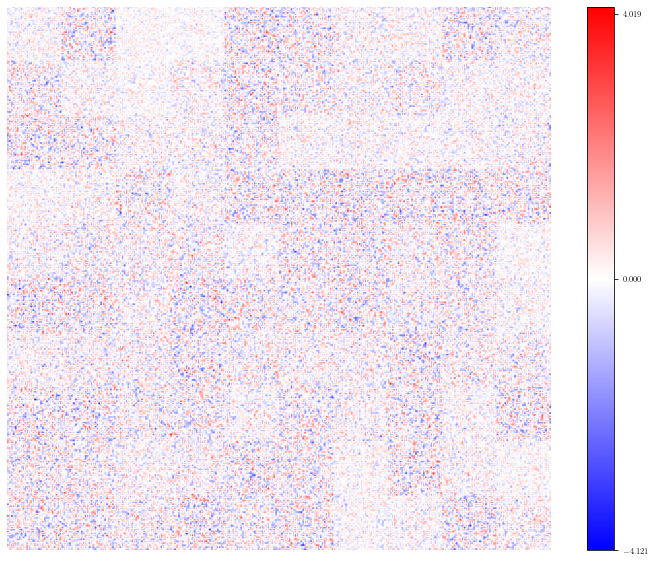

In [202]:
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

### One-by-One comparison

In [533]:
# Inputs

i = 3
input_KH = np.transpose(M[i*Num:(i+1)*Num,:])
input = torch.DoubleTensor(M[i*Num:(i+1)*Num, :])
input._requires_grad=False

In [534]:
input.dtype

torch.float64

In [615]:
# define a distance measure

def LpDist(x, y, p=2.):
    x = torch.DoubleTensor(x)
    y = torch.DoubleTensor(y)
    d = (x - y)**p
    return d.sum()

def is_zero_tensor(x, p=1., atol=1e-4):
    x = torch.DoubleTensor(x)
    d = torch.abs(x)**p
    is_zero = (d - atol) < 0
    return is_zero.all()

In [536]:
LpDist(input_KH, input.T)

tensor(0., dtype=torch.float64)

In [537]:
b_inp_KH = bracket(synapses, input_KH)

In [538]:
b_inp = model._bracket(input, model.W)

In [539]:
LpDist(b_inp_KH, b_inp.T)

tensor(6.5328e-09, dtype=torch.float64, grad_fn=<SumBackward0>)

In [540]:
diff = torch.DoubleTensor(b_inp_KH) - torch.DoubleTensor(b_inp.T)
is_zero_tensor(diff, atol=1e-4)

tensor(True)

In [541]:
g_model = model._g(b_inp)
g_KH = g(b_inp_KH, k=7)

In [542]:
LpDist(model._g(b_inp), g(b_inp_KH, k=7).T)

tensor(0., dtype=torch.float64)

In [543]:
s_inc = ds(g_KH, b_inp_KH)

In [544]:
w_inc = model.weight_increment(input)
nc = max(w_inc.abs().max(), prec)
w_inc = w_inc / nc

In [545]:
w_inc.shape

torch.Size([784, 100])

In [546]:
LpDist(w_inc, s_inc.T)

tensor(0.0034, dtype=torch.float64, grad_fn=<SumBackward0>)

In [547]:
w_diff = torch.DoubleTensor(s_inc.T) - torch.DoubleTensor(w_inc)
is_zero_tensor(w_diff, atol=1e-2)

tensor(True)

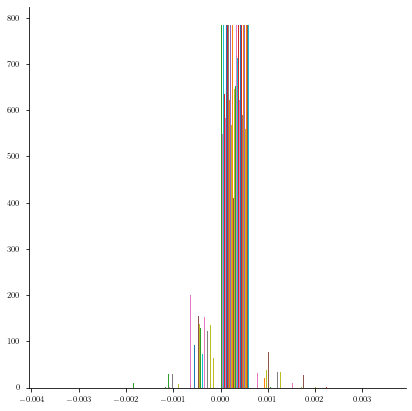

In [548]:
fig, ax = plt.subplots()
ax.hist(w_diff.detach().cpu().numpy())
fig.show()

In [549]:
### a whole mini-batch

# initialisation

Nep = 100
synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)

llPSet = FKHL3.pSet
llPSet["hidden_size"]= hid

model = FKHL3(llPSet)
W_lp = []
s_lp = []

with torch.no_grad():
    model.W = torch.nn.Parameter(torch.Tensor(synapses).T)
    model.double()
    
    for nep in range(Nep):
        eps=eps0*(1-nep/Nep)
        model.pSet["lambda"] = eps
        M=M[np.random.permutation(Ns),:]
        for i in range(Ns//Num):
            # Krotov and Hopfield model
            inputs=np.transpose(M[i*Num:(i+1)*Num,:])
            tot_input = bracket(synapses, inputs)
            yl = g(tot_input, k=7)
            dsynapses = ds(yl, tot_input)
            synapses += eps*dsynapses

            model.train_step_fast(torch.DoubleTensor(inputs).T)
            
        F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
        W_lp.append(F_norm.mean().detach().cpu().numpy())
        F_norm = np.power(np.absolute(synapses), model.pSet["p"]).sum(axis=-1)
        s_lp.append(F_norm.mean())

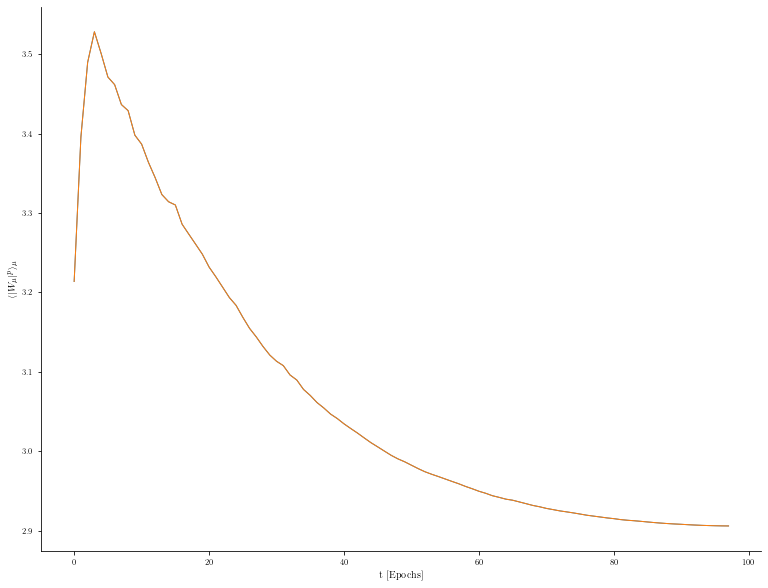

In [550]:
fig, ax = plt.subplots(figsize=(12.9, 10))
ax.plot(np.array(W_lp)[2:])
ax.plot(np.array(s_lp)[2:])
ax.set_xlabel(r"t [Epochs]")
ax.set_ylabel(r"$\langle |W_{\mu}|^{p} \rangle_{\mu}$")
fig.show()

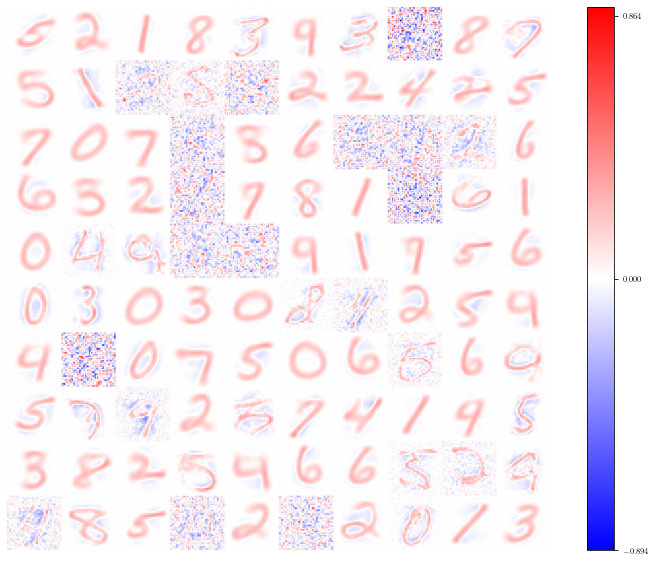

In [524]:
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

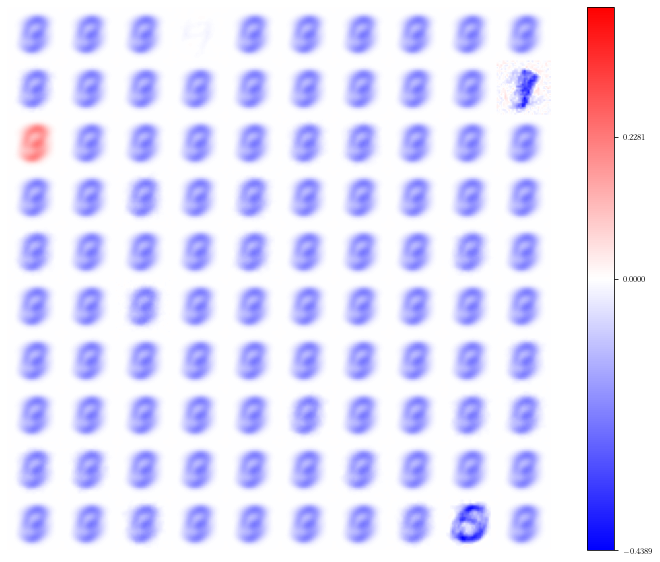

In [634]:
W = model.W.detach().cpu().numpy()
W = W.T
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=W[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

In [551]:
LpDist(b_inp_KH, b_inp.T)

tensor(6.5328e-09, dtype=torch.float64, grad_fn=<SumBackward0>)

In [529]:
diff = torch.DoubleTensor(b_inp_KH) - torch.DoubleTensor(b_inp.T)
is_zero_tensor(diff, atol=1e-8)

tensor(False)

## Convergence study

Double Precision

In [633]:
### a whole mini-batch

# initialisation

T = 2.0
#synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)

llPSet = FKHL3.pSet
llPSet["hidden_size"]= hid
model = FKHL3(llPSet)
W_init = model.W.clone()

W_lp = []
err = []
eps = [1.0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

with torch.no_grad():
    #model.W = torch.nn.Parameter(torch.Tensor(synapses).T)
    
    # BASELINE RUN
    model.W = nn.Parameter(W_init)
    model.double()
    model.pSet["lambda"] = eps[0]
    Nep = int(T // eps[0])
    for nep in range(Nep):
        M=M[np.random.permutation(Ns),:]
        for i in range(Ns // Num):
            inputs = M[i*Num:(i+1)*Num, :]
            model.train_step_fast(torch.DoubleTensor(inputs))
        
    F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
    W_lp.append(F_norm.mean().detach().cpu().numpy())
    W0 = model.W.clone()
    
    for e in range(1, len(eps)):
        model.W = nn.Parameter(W_init)
        model.double()
        model.pSet["lambda"] = eps[e]
        Nep = int(T // eps[e])
        for nep in range(Nep):
            M=M[np.random.permutation(Ns),:]
            for i in range(Ns // Num):
                inputs = M[i*Num:(i+1)*Num, :]
                model.train_step_fast(torch.DoubleTensor(inputs))
            
        F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
        W_lp.append(F_norm.mean().detach().cpu().numpy())
        err.append(LpDist(W0, model.W))
        W0 = model.W.clone()

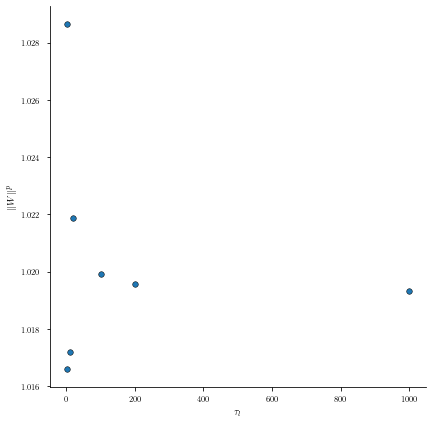

In [630]:
fig, ax = plt.subplots()
ax.plot((1 / np.array(eps)), np.array(W_lp), 'o')
ax.set_xlabel(r"$\tau_{l}$")
ax.set_ylabel(r"$\|W\|^{p}$")
fig.show()

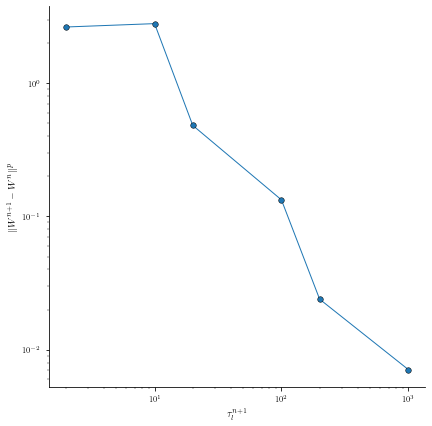

In [631]:
fig, ax = plt.subplots()
ax.loglog((1 / np.array(eps))[1:], np.array(err), 'o-')
ax.set_xlabel(r"$\tau_{l}^{n+1}$")
ax.set_ylabel(r"$\|W^{n+1} - W^{n}\|^{p}$")
fig.show()

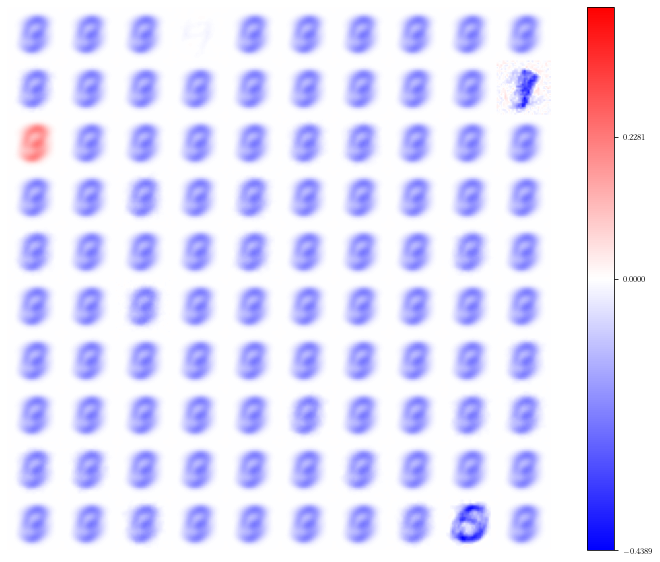

In [635]:
W = model.W.detach().cpu().numpy()
W = W.T
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=W[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()

Single Precision

In [593]:
# define a single precision distance measure

def LpDistSingle(x, y, p=2.):
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    d = (x - y)**p
    return d.sum()

def is_zero_tensor_single(x, p=1., atol=1e-4):
    x = torch.Tensor(x)
    d = torch.abs(x)**p
    is_zero = (d - atol) < 0
    return is_zero.all()

In [616]:
### a whole mini-batch

# initialisation

T = 2.0
#synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)

llPSet = FKHL3.pSet
llPSet["hidden_size"]= hid
model = FKHL3(llPSet)
W_init = model.W.clone()

W_lp_single = []
err_single = []
eps = [1.0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

with torch.no_grad():
    #model.W = torch.nn.Parameter(torch.Tensor(synapses).T)
    
    # BASELINE RUN
    model.W = nn.Parameter(W_init)
    model.float()
    model.pSet["lambda"] = eps[0]
    Nep = int(T // eps[0])
    for nep in range(Nep):
        for i in range(Ns // Num):
            inputs = M[i*Num:(i+1)*Num, :]
            model.train_step_fast(torch.Tensor(inputs))
        
    F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
    W_lp.append(F_norm.mean().detach().cpu().numpy())
    W0 = model.W.clone()
    
    for e in range(1, len(eps)):
        model.W = nn.Parameter(W_init)
        model.float()
        model.pSet["lambda"] = eps[e]
        Nep = int(T // eps[e])
        for nep in range(Nep):     
            for i in range(Ns // Num):
                inputs = M[i*Num:(i+1)*Num, :]
                model.train_step_fast(torch.Tensor(inputs))
            
        F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
        W_lp_single.append(F_norm.mean().detach().cpu().numpy())
        err_single.append((torch.abs(W0-model.W)**2).sum().detach().cpu().numpy())
        W0 = model.W.clone()

KeyboardInterrupt: 

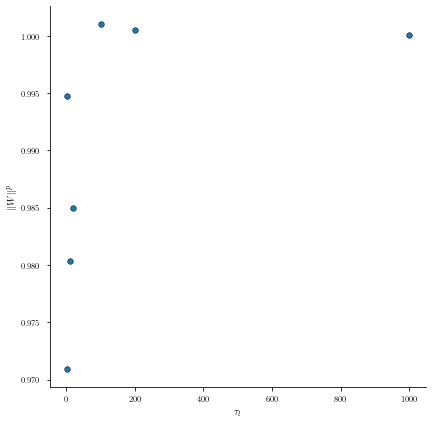

In [598]:
fig, ax = plt.subplots()
ax.plot((1 / np.array(eps)), np.array(W_lp)[9:], 'o')
ax.set_xlabel(r"$\tau_{l}$")
ax.set_ylabel(r"$\|W\|^{p}$")
fig.show()

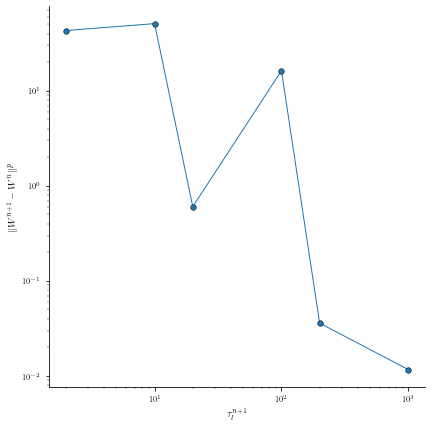

In [601]:
fig, ax = plt.subplots()
ax.loglog((1 / np.array(eps))[1:], np.array(err)[6:], 'o-')
ax.set_xlabel(r"$\tau_{l}^{n+1}$")
ax.set_ylabel(r"$\|W^{n+1} - W^{n}\|^{p}$")
fig.show()

Double Precision on GPU

In [618]:
### a whole mini-batch

# initialisation

T = 2.0
#synapses = np.random.normal(mu, sigma, (hid, N)).astype(np.double)

llPSet = FKHL3.pSet
llPSet["hidden_size"]= hid
model = FKHL3(llPSet)
W_init = model.W.clone()

W_lp_double_gpu = []
err_double_gpu = []
eps = [1.0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

with torch.no_grad():
    #model.W = torch.nn.Parameter(torch.Tensor(synapses).T)
    
    # BASELINE RUN
    model.W = nn.Parameter(W_init)
    #model.float()
    model.to(dev)
    model.double()
    model.pSet["lambda"] = eps[0]
    Nep = int(T // eps[0])
    for nep in range(Nep):
        for i in range(Ns // Num):
            inputs = M[i*Num:(i+1)*Num, :]
            model.train_step_fast(torch.DoubleTensor(inputs).to(dev))
        
    F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
    W_lp_double_gpu.append(F_norm.mean().detach().cpu().numpy())
    W0 = model.W.clone()
    
    for e in range(1, len(eps)):
        model.W = nn.Parameter(W_init)
        #model.float()
        model.to(dev)
        model.double()
        model.pSet["lambda"] = eps[e]
        Nep = int(T // eps[e])
        for nep in range(Nep):     
            for i in range(Ns // Num):
                inputs = M[i*Num:(i+1)*Num, :]
                model.train_step_fast(torch.DoubleTensor(inputs).to(dev))
            
        F_norm = torch.pow(torch.abs(model.W), model.pSet["p"]).sum(dim=0)
        W_lp_double_gpu.append(F_norm.mean().detach().cpu().numpy())
        err_double_gpu.append((torch.abs(W0 - model.W)**2).detach().cpu().numpy())
        W0 = model.W.clone()

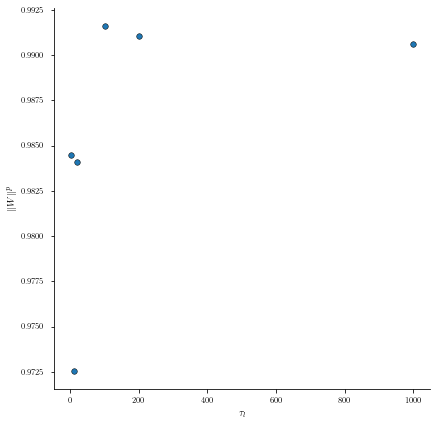

In [620]:
fig, ax = plt.subplots()
ax.plot((1 / np.array(eps))[1:], np.array(W_lp_double_gpu), 'o')
ax.set_xlabel(r"$\tau_{l}$")
ax.set_ylabel(r"$\|W\|^{p}$")
fig.show()

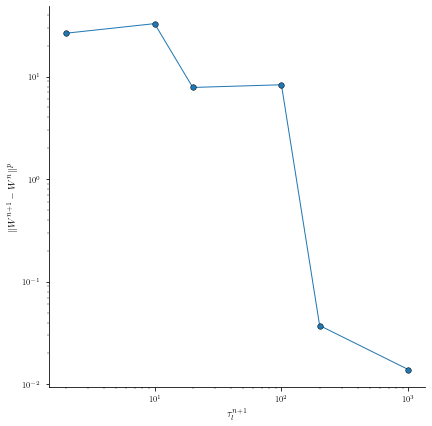

In [625]:
fig, ax = plt.subplots()
ax.loglog((1 / np.array(eps))[1:], np.array(err_double_gpu).sum(axis=(-1, -2)), 'o-')
ax.set_xlabel(r"$\tau_{l}^{n+1}$")
ax.set_ylabel(r"$\|W^{n+1} - W^{n}\|^{p}$")
fig.show()

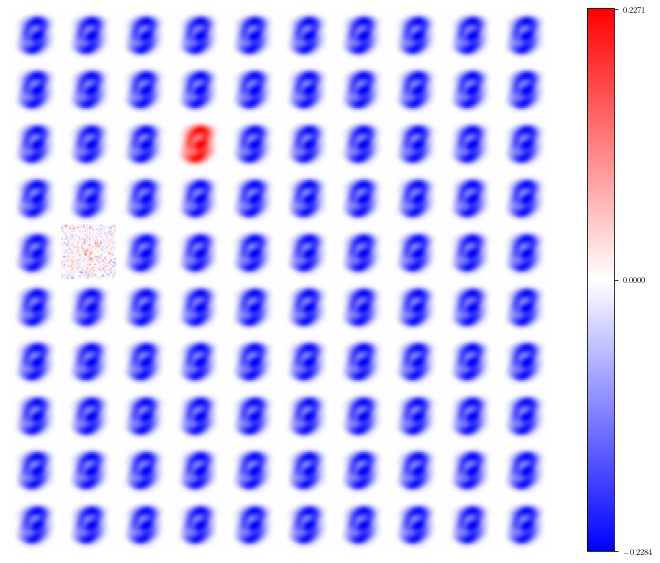

In [628]:
W = model.W.detach().cpu().numpy()
W = W.T
fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((28*Ky,28*Kx))
for y in range(Ky):
    for x in range(Kx):
        HM[y*28:(y+1)*28,x*28:(x+1)*28]=W[yy,:].reshape(28,28)
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
fig.show()